# Prac 2: Predator-Prey (Lotka Volterra)

## The Statistical Model

This example follows a simple analysis of the Lotka Volterra model for preditor and prey populations where the measurement error for the data is assumed to be Gaussian.

$X_{1,t}$ the population of the prey, $X_{2,t}$ the population of the predator at time $t$. These evolve acording to:

$$
\frac{dx_1}{dt} = (\alpha -\beta x_2 )x_1 \qquad
\frac{dx_2}{dt} = (\beta x_1 - \gamma )x_2     
$$

Observe a noisy measurement at times $t=0, 2, ..., 50$. 
$$
Y_{1,t} \sim \mathcal{N}(X_{1,t}, \sigma^2), \qquad Y_{2,t} \sim \mathcal{N}(X_{2,t}, \sigma^2)
$$

We implement this model and simulate data with paramters $\alpha=0.3$, $\beta = 0.04$, $\gamma=0.5$ and $\sigma = 1$. 


### Simulate some data

First we need to define the ODE in Julia. 

In [1]:
using DifferentialEquations

# Define the deterministic model
function lotka_volterra(dx, x, p, t)
    # Model parameters.
    α, β, γ = p
    # Current state.
    x1, x2 = x
    # Evaluate differential equations.
    dx[1] = (α - β * x2) * x1 # prey
    dx[2] = (β * x1 - γ) * x2 # predator

    return nothing
end


lotka_volterra (generic function with 1 method)

Then simulate some data and plot the results. It is importatnt to have the Random library imported to make sure that the data is simulated with the same seed. Alternatively you could load in the data using the lines commented out in the code snippet below. Assume that the initial populations are $x_{1,0} = 7$ and $x_{2,0} = 5$ and that $\theta = (.3, .04, .5, 1)$

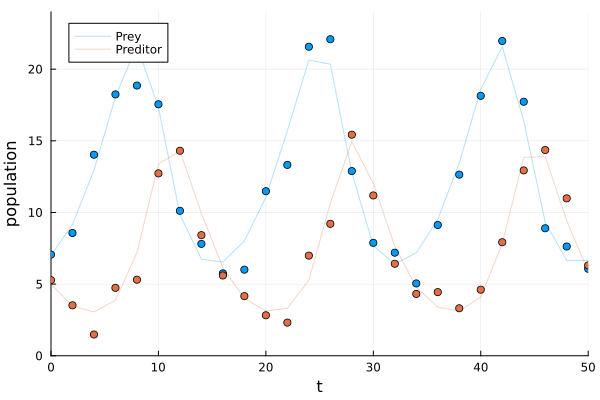

In [2]:
# Set a seed for reproducibility and import plotting packages
using Random
using StatsPlots

Random.seed!(1)
x0 = [7, 5]
tspan = (0.0, 50.0)
θ_dg = [0.3, 0.04, 0.5, 1.] # The data generating θ
prob = ODEProblem(lotka_volterra, x0, tspan)

save_at = 2.0
sol = solve(prob, p = θ_dg[1:3], saveat=save_at,  verbose = false)

# Noisy observations
y = Array(sol) + 1.0 * randn(size(Array(sol))) 

plot(sol; alpha=0.3, labels = ["Prey" "Preditor"], ylim =[0.0, 24], ylabel="population")
scatter!(sol.t, y'; color=[1 2], label="")

# using DelimitedFiles
# y = readdlm("lvsmc/prey_pred2.csv", ',', Float64)

## Define the likelihood and priors

For numerical stability we use the log likelihood of the data. We can evaluate the likelihood of the data for a set of parameters $\theta = (\alpha, \beta, \gamma, \sigma)$ by solving the ODE and calculating the probability of observing the noisy (Gaussian) measurements. 

In [3]:
function log_like(θ)

    α, β, γ, σ =  θ

    # Simulate Lotka-Volterra model. 
    predicted = solve(prob, p=[α, β, γ], saveat = save_at, verbose=false)

    if !SciMLBase.successful_retcode(predicted.retcode)
        # Simulation failed, return negative infinity
        return -Inf
    end

    # Add up the log likelihood for the observed data y.
    log_likelihood = 0.0
    Σ = diagm([σ^2, σ^2])
    for i in 1:length(predicted)
        like_dist = MultivariateNormal(predicted[:,i], Σ)
        log_likelihood += logpdf(like_dist, y[:,i])
    end
    return log_likelihood
end

log_like (generic function with 1 method)

We want to estimate ${\theta} = (\alpha, \beta, \gamma, \sigma)$ for the model. The Bayesian approach allows us to do this and to quantify the uncertainty of our estimates.

Assign some priors $\alpha, \gamma \sim U(0,1)$ $\beta \sim U(0,0.1)$ and $\sigma \sim U(0.1,7)$. For the SMC code we will need functions to evaluate the log prior and to simulate from the prior.

In [4]:
using Distributions
# Priors on: α, β, γ, σ 
priors = [Uniform(0., 1), Uniform(0,0.1), Uniform(0, 1), Uniform(0.1, 7)]

# Function to simulate from the prior
function sim_prior(N)
    mat = zeros(N, length(priors))
    for i in 1:N
        mat[i,:] = rand.(priors)
    end
    return mat
end

# Function to evaluate the log prior
function log_prior(θ)
    # Prior distributions.
    return sum(logpdf.(priors, θ))
end

log_prior (generic function with 1 method)

## Import the SMC code and run the algorithm

The SMC algorithm is discussed in the Prac_1 notebook and the code is imported into the session. Use the code to run the SMC algorithm, this may take a while to evaluate.

In [5]:
include("smc_sampler_lanneal.jl")
particles = smc_sampler_lanneal(1000, sim_prior, log_prior, log_like, γ = range(0, stop=1, length=15).^5, R=20)


Current γ = 4.038610734061924e-7
Unique particles: 

1000
Current γ = 1.2923554348998157e-5
Unique particles: 1000


Current γ = 9.813824083770477e-5
Unique particles: 1000


Current γ = 0.00041355373916794104
Unique particles: 1000


Current γ = 0.0012620658543943514
Unique particles: 1000


Current γ = 0.0031404237068065528
Unique particles: 1000


Current γ = 0.0067876930607378766
Unique particles: 1000


Current γ = 0.013233719653374113
Unique particles: 1000


Current γ = 0.023847592523562257
Unique particles: 998


Current γ = 0.040386107340619246
Unique particles: 994


Current γ = 0.06504222973314072
Unique particles: 940


Current γ = 0.10049355861780969
Unique particles: 705


Current γ = 0.14995078952820548
Unique particles: 423


Current γ = 0.21720617794361205
Unique particles: 596


Current γ = 0.30668200261782746
Unique particles: 806


Current γ = 0.4234790289079716
Unique particles: 898


Current γ = 0.5734249721032963
Unique particles: 951


Current γ = 0.7631229607539922
Unique particles: 997


Current γ = 1.0
Unique particles: 1000


1000×4 Matrix{Float64}:
 0.30008   0.0397522  0.490395  1.1682
 0.293765  0.0402048  0.511155  1.12918
 0.296909  0.0402206  0.503108  1.078
 0.296612  0.0402986  0.499428  0.914804
 0.296993  0.0405982  0.504201  0.971132
 0.293344  0.0405804  0.50109   1.09393
 0.299001  0.039825   0.500007  1.11544
 0.297591  0.0406062  0.49118   1.26233
 0.292263  0.0404262  0.51349   1.01978
 0.290973  0.0416794  0.515666  1.03012
 ⋮                              
 0.29336   0.0406511  0.510195  0.868424
 0.299727  0.0392442  0.489956  1.08396
 0.300759  0.0394611  0.492245  1.08842
 0.299913  0.0395269  0.491374  0.932594
 0.299314  0.0403525  0.493406  0.962536
 0.290668  0.0412729  0.521344  1.03338
 0.299273  0.039907   0.493417  1.15663
 0.291542  0.0406571  0.514261  0.929506
 0.291556  0.0408778  0.512954  1.02894

Compare the marginal distributions of the parameters to the data generating values.

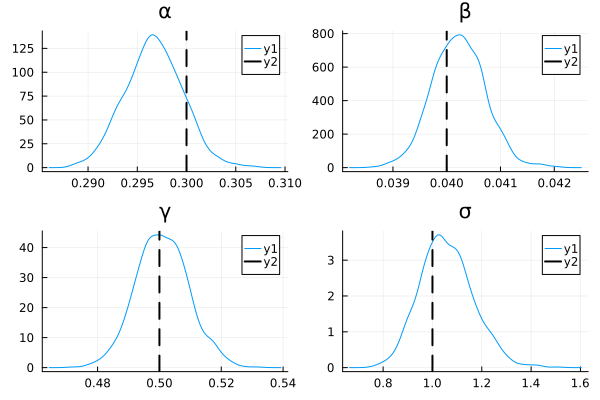

In [6]:
using KernelDensity

names = ["α", "β", "γ", "σ"]
p = []
for i in 1:4
    # dens = kde(exp.(samps[:,i]))
    dens = kde(particles[:,i])

    #x_tic = min(dens.x)
    p_l = plot(dens, title = names[i], ticks = :native)
    vline!([(θ_dg[i])], line = (:black, 2, :dash))
    push!(p,  p_l)
end
plot(p[1], p[2], p[3], p[4])